In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

#CONSTANTS
number_of_Na = 19
number_of_Bi = 17
number_of_Ti = 36
number_of_O = 106
dt = 10*10**(-15) #s


def compute_velocity_autocorrelation(v):
   #  x = np.array(v) 
   #  mean = np.mean(v)
   #  var = np.var(v)
   #  ndata = v - mean
   autocorrelation = np.correlate(v, v, "full")[len(v)-1:] 
   #autocorrelation = autocorrelation/np.max(autocorrelation)
   return autocorrelation


def compute_velocity_autocorrelation(v):
   autocorrelation = np.correlate(v, v, "full")[len(v)-1:] 
   return autocorrelation

def compute_integrated_autocorrelation(autocorrelation, xx):
    integrated_autocorrelation = np.trapz(autocorrelation, x=xx)
    return integrated_autocorrelation

def exponential_moving_average(data, alpha):
    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]
    for i in range(1, len(data)):
        smoothed_data[i] = alpha * data[i] + (1 - alpha) * smoothed_data[i-1]
    return smoothed_data


potim = 3                               #timestep from INCAR file
readfile = open('2.XDATCAR',"r")        #input XDATCAR file in format XDATCAR
z=0                                     #counter
natoms=0                                #number of atoms in XDATCAR file
posion = []                             #atom positions in Cartesian coordinates
confcount = 0                           #number of structures in XDATCAR file
direct=[]                               #number of time steps for each structure in XDATCAR file
a=[]                                    #lattice parameter in 1st dimension
b=[]                                    #lattice parameter in 2nd dimension
c=[]                                    #lattice parameter in 3rd dimension
#read in XDATCAR file
line=readfile.readline()
while (line):
  z=z+1
  line.strip()
  line=re.sub('^',' ',line)
  y=line.split()
  if (z==2):
     scale=float(y[0])
  if (z==3):
     a.append(float(y[0])*10**(-8))
     a.append(float(y[1])*10**(-8))
     a.append(float(y[2])*10**(-8))
     a_len=(a[0]*a[0]+a[1]*a[1]+a[2]*a[2])**0.5
  if (z==4):
     b.append(float(y[0])*10**(-8))
     b.append(float(y[1])*10**(-8))
     b.append(float(y[2])*10**(-8))
     b_len=(b[0]*b[0]+b[1]*b[1]+b[2]*b[2])**0.5
  if (z==5):
     c.append(float(y[0])*10**(-8))
     c.append(float(y[1])*10**(-8))
     c.append(float(y[2])*10**(-8))
     c_len=(c[0]*c[0]+c[1]*c[1]+c[2]*c[2])**0.5
  if (z==7):
     natoms=int(y[3])
  if (y[0]=="Direct"):
     direct.append(int(y[2]))
     posion.append([])
     for i in range(178):
        line=readfile.readline()
        if number_of_Na+number_of_Bi+number_of_Ti <= i < 178:
           line.strip()
           line=re.sub('^',' ',line)
           f=line.split()
           cartpos_x=a[0]*float(f[0])+a[1]*float(f[1])+a[2]*float(f[2])
           cartpos_y=b[0]*float(f[0])+b[1]*float(f[1])+b[2]*float(f[2])
           cartpos_z=c[0]*float(f[0])+c[1]*float(f[1])+c[2]*float(f[2])
           #positions of ions for each structure are obtained here
           posion[confcount].append([cartpos_x,cartpos_y,cartpos_z])
     confcount=confcount+1
  line=readfile.readline()
readfile.close

<function TextIOWrapper.close()>

In [ ]:
for i in range(0,confcount-1):
   d = 0
   for j in range(0,number_of_O):
      x_diff=posion[i+1][j][0]-posion[i][j][0]
      #if length is larger than 0.5 (in crystallographic coordinates) 
      # then we have to shift atom
      #due to periodic image to obtain the shortest distance.
      #periodic boundary conditions
      if (abs(x_diff)>(0.5*a_len)):
         if (x_diff<0):
            x_diff=x_diff+a_len
         elif (x_diff>0):
            x_diff=x_diff-a_len
      y_diff=posion[i+1][j][1]-posion[i][j][1]
      if (abs(y_diff)>(0.5*b_len)):
         if (y_diff<0):
            y_diff=y_diff+b_len
         elif (y_diff>0):
            y_diff=y_diff-b_len
      z_diff=posion[i+1][j][2]-posion[i][j][2]
      if (abs(z_diff)>(0.5*c_len)):
         if (z_diff<0):
            z_diff=z_diff+c_len
         elif (z_diff>0):
            z_diff=z_diff-c_len
      posion[i+1][j][0] = posion[i][j][0] + x_diff
      posion[i+1][j][1] = posion[i][j][1] + y_diff
      posion[i+1][j][2] = posion[i][j][2] + z_diff

In [ ]:
#velocity calculating
velocity = np.zeros((confcount-1, number_of_O, 3))
for i in range(0, confcount-1):
   for j in range(0,number_of_O):
      x_diff=posion[i+1][j][0]-posion[i][j][0]
      y_diff=posion[i+1][j][1]-posion[i][j][1]
      z_diff=posion[i+1][j][2]-posion[i][j][2]
      velocity[i][j][0] = x_diff/dt 
      velocity[i][j][1] = y_diff/dt 
      velocity[i][j][2] = z_diff/dt

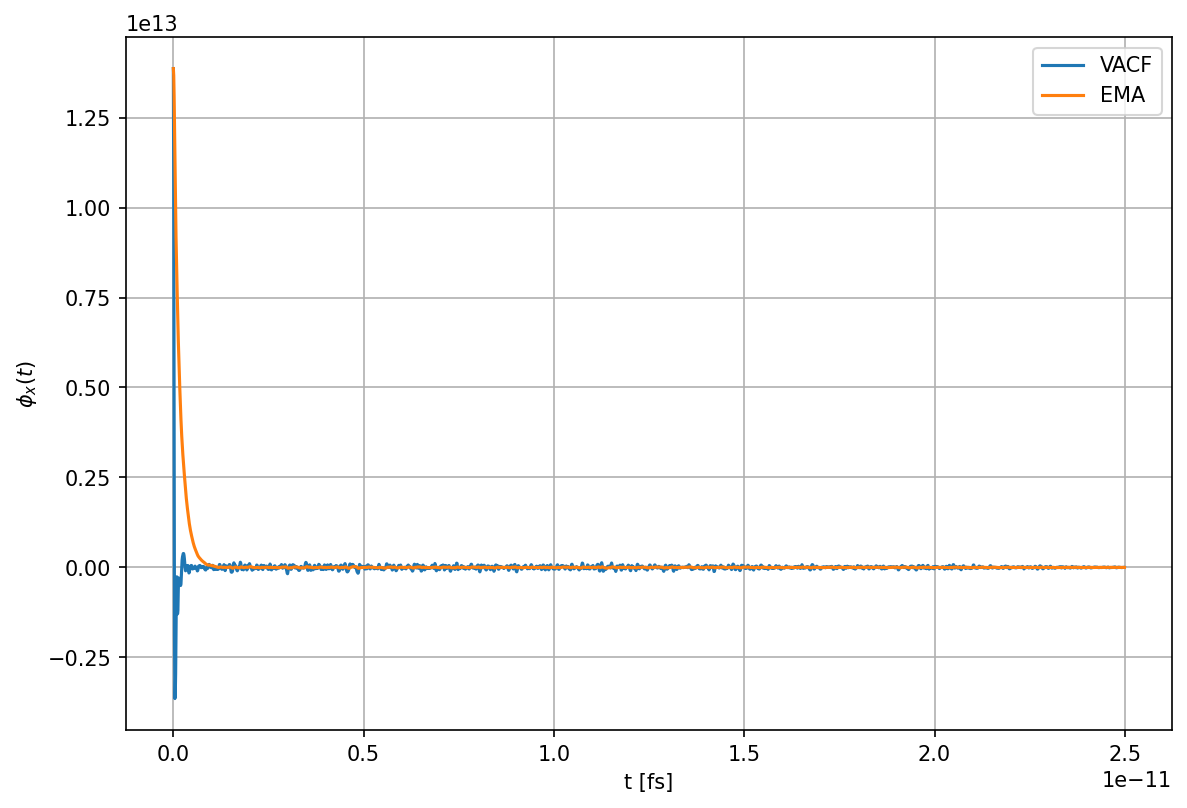

In [ ]:
phi_x, phi_y, phi_z = 0, 0, 0
for j in range(0, number_of_O):
    autocorr_O_x = compute_velocity_autocorrelation(velocity[:, j, 0])
    autocorr_O_y = compute_velocity_autocorrelation(velocity[:, j, 1])
    autocorr_O_z = compute_velocity_autocorrelation(velocity[:, j, 2])
    phi_x += autocorr_O_x
    phi_y += autocorr_O_y
    phi_z += autocorr_O_z


fig, ax = plt.subplots(dpi=150, figsize=(9, 6))
time = np.linspace(0, 24990, 2499)*10**(-15)
phi_x = phi_x/number_of_O
phi_y = phi_y/number_of_O
phi_z = phi_z/number_of_O
plt.plot(time, phi_x, label = "VACF")
smoothed_phi_x = exponential_moving_average(phi_x, 0.055)
smoothed_phi_y = exponential_moving_average(phi_y, 0.055)
smoothed_phi_z = exponential_moving_average(phi_z, 0.055)
ax.plot(time, smoothed_phi_x, label = "EMA")
ax.set_xlabel('t [fs]')
ax.set_ylabel(r'$\phi_{x}(t)$')
ax.legend()
plt.title('Velocity autocorrelation function for O atoms')
ax.grid(which='major')
plt.show()

In [ ]:
D_x = compute_integrated_autocorrelation(phi_x, time) / 3
D_y = compute_integrated_autocorrelation(phi_y, time) / 3
D_z = compute_integrated_autocorrelation(phi_z, time) / 3 
print(np.sqrt(D_x**2+D_y**2+D_z**2)) #cm^2/s

0.001997120089481061
